In [1]:
from google.colab import drive
drive.mount("/content/drive")

BASE_PATH = "/content/drive/MyDrive/Satellite Imagery Based Property Valuation"

TRAIN_CSV = f"{BASE_PATH}/train(1).csv"
TEST_CSV  = f"{BASE_PATH}/test2.csv"

TRAIN_IMG_DIR = f"{BASE_PATH}/images/train"
TEST_IMG_DIR  = f"{BASE_PATH}/images/test"

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
from PIL import Image
import torch
import torch.nn.functional as F
from torchvision import models, transforms

In [ ]:
df = pd.read_csv(TRAIN_CSV)
df.sample(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8575,3275300050,20141124T000000,272000,3,3.00,2430,10500,1.0,0,0,...,8,2150,280,1983,0,98003,47.2579,-122.312,1670,9800
6378,3204400040,20150304T000000,273950,3,2.25,1570,3109,2.0,0,0,...,8,1570,0,2002,0,98092,47.3258,-122.186,1680,3590
1722,8835900086,20140902T000000,350000,4,3.00,3380,16133,1.0,0,1,...,8,2330,1050,1959,0,98118,47.5501,-122.261,2500,11100
4876,7345000340,20150203T000000,208000,3,1.00,1020,6120,1.0,0,0,...,7,1020,0,1967,0,98002,47.2780,-122.205,1370,8000
1573,2310030490,20150323T000000,292500,3,2.25,1390,6004,2.0,0,0,...,8,1390,0,1993,0,98038,47.3536,-122.047,1630,6397


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16209 entries, 0 to 16208
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             16209 non-null  int64  
 1   date           16209 non-null  object 
 2   price          16209 non-null  int64  
 3   bedrooms       16209 non-null  int64  
 4   bathrooms      16209 non-null  float64
 5   sqft_living    16209 non-null  int64  
 6   sqft_lot       16209 non-null  int64  
 7   floors         16209 non-null  float64
 8   waterfront     16209 non-null  int64  
 9   view           16209 non-null  int64  
 10  condition      16209 non-null  int64  
 11  grade          16209 non-null  int64  
 12  sqft_above     16209 non-null  int64  
 13  sqft_basement  16209 non-null  int64  
 14  yr_built       16209 non-null  int64  
 15  yr_renovated   16209 non-null  int64  
 16  zipcode        16209 non-null  int64  
 17  lat            16209 non-null  float64
 18  long  

In [ ]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,1.620900e+04,1.620900e+04,16209.00000,16209.000000,16209.000000,1.620900e+04,16209.000000,16209.000000,16209.000000,16209.000000,16209.000000,16209.000000,16209.000000,16209.000000,16209.000000,16209.000000,16209.000000,16209.000000,16209.000000,16209.000000
mean,4.575771e+09,5.374703e+05,3.36782,2.113054,2073.274601,1.486767e+04,1.498828,0.006971,0.234253,3.407860,7.652971,1784.754396,288.520205,1971.152755,82.738108,98077.974767,47.560707,-122.214003,1983.152261,12735.572707
std,2.874661e+09,3.603036e+05,0.93327,0.765242,907.009491,3.882570e+04,0.543032,0.083206,0.763152,0.651553,1.171050,821.820844,438.598910,29.372698,397.861148,53.355282,0.138340,0.140093,681.905161,26933.162012
min,1.000102e+06,7.500000e+04,0.00000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.159300,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.200000e+05,3.00000,1.500000,1430.000000,5.004000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1952.000000,0.000000,98033.000000,47.472500,-122.328000,1480.000000,5098.000000
50%,3.904950e+09,4.500000e+05,3.00000,2.250000,1910.000000,7.599000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.572400,-122.230000,1840.000000,7620.000000
75%,7.304301e+09,6.400000e+05,4.00000,2.500000,2550.000000,1.063100e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2200.000000,560.000000,1997.000000,0.000000,98117.000000,47.678200,-122.125000,2360.000000,10053.000000
max,9.900000e+09,7.700000e+06,33.00000,8.000000,12050.000000,1.164794e+06,3.500000,1.000000,4.000000,5.000000,13.000000,8860.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [ ]:
df['id'].duplicated().sum()

np.int64(99)

In [ ]:
df = df.drop_duplicates(subset='id', keep='first')

## EDA

### Univariate

In [ ]:
target = "price"

numerical_cols = [
    'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
    'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
    'lat', 'long', 'sqft_living15', 'sqft_lot15'
]

categorical_cols = [
    'floors', 'waterfront', 'view', 'condition', 'grade'
]

date_col = 'date'


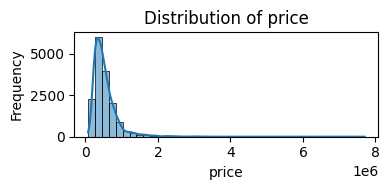

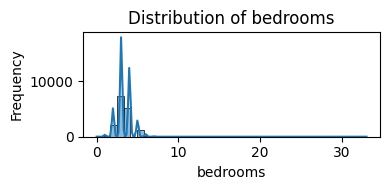

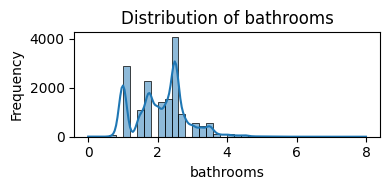

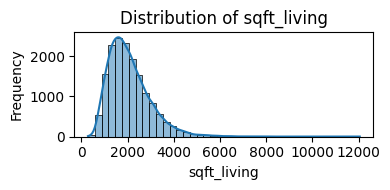

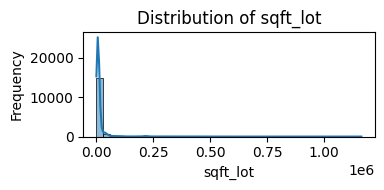

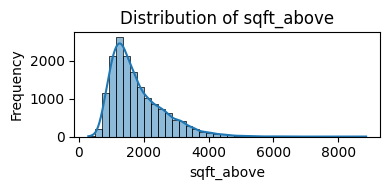

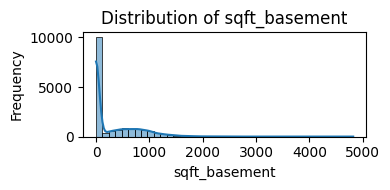

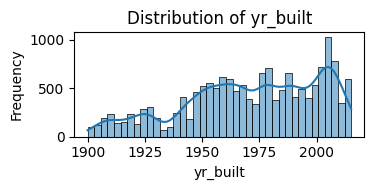

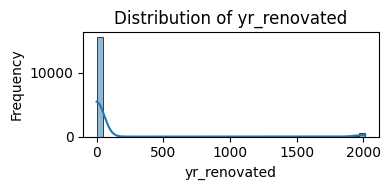

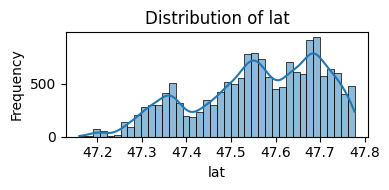

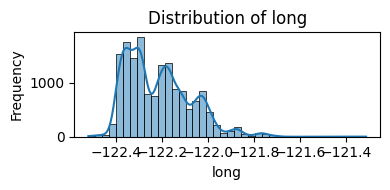

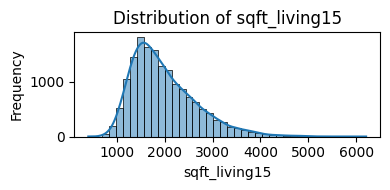

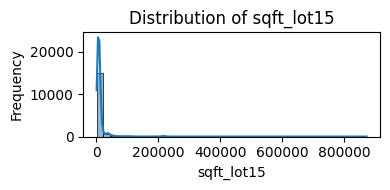

In [ ]:
for col in numerical_cols:
    plt.figure(figsize=(4, 2))

    sns.histplot(df[col], bins=40, kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()



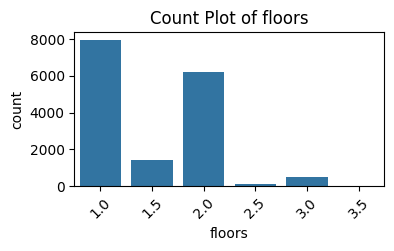

floors
1.0    7970
2.0    6215
1.5    1414
3.0     489
2.5     117
3.5       4
Name: count, dtype: int64
----------------------------------------


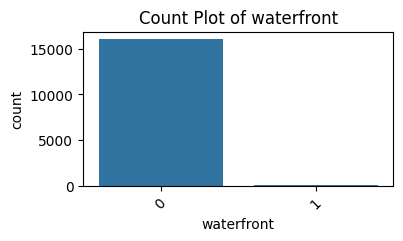

waterfront
0    16096
1      113
Name: count, dtype: int64
----------------------------------------


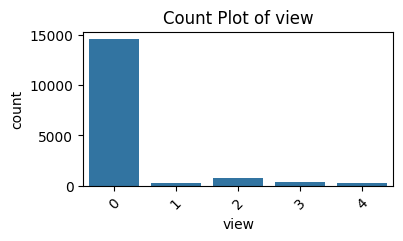

view
0    14604
2      743
3      375
1      254
4      233
Name: count, dtype: int64
----------------------------------------


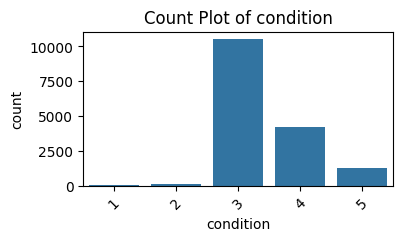

condition
3    10538
4     4238
5     1277
2      131
1       25
Name: count, dtype: int64
----------------------------------------


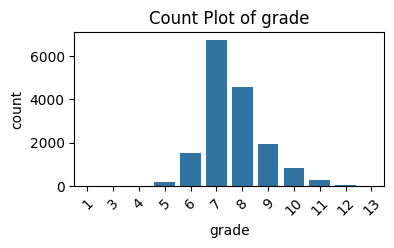

grade
7     6761
8     4563
9     1943
6     1511
10     861
11     286
5      183
12      63
4       24
13      10
3        3
1        1
Name: count, dtype: int64
----------------------------------------


In [ ]:
for col in categorical_cols:
    plt.figure(figsize=(4, 2))
    sns.countplot(x=df[col])
    plt.title(f"Count Plot of {col}")
    plt.xticks(rotation=45)
    plt.show()

    print(df[col].value_counts())
    print("-" * 40)


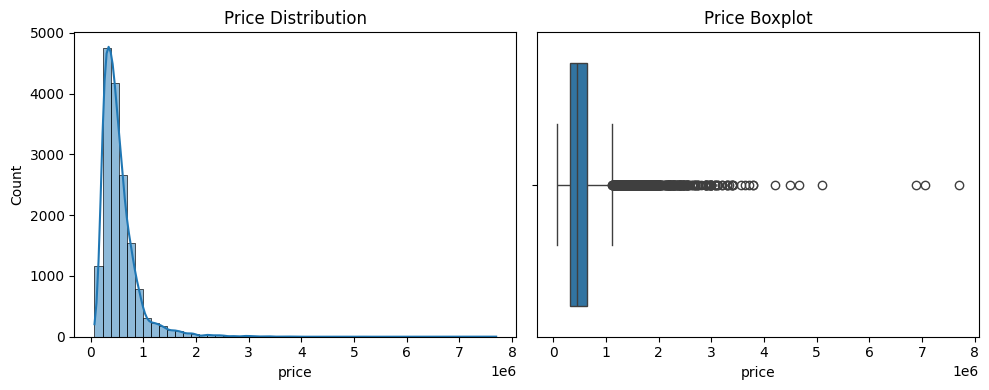

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.histplot(df['price'], bins=50, kde=True)
plt.title("Price Distribution")

plt.subplot(1, 2, 2)
sns.boxplot(x=df['price'])
plt.title("Price Boxplot")

plt.tight_layout()
plt.show()


### Price vs Key Features

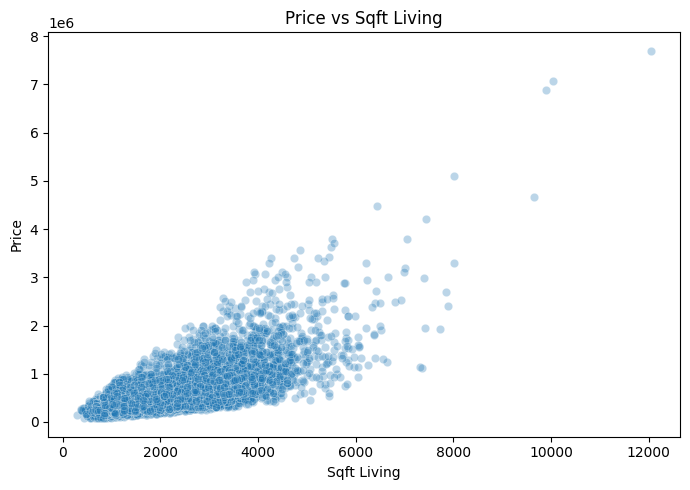

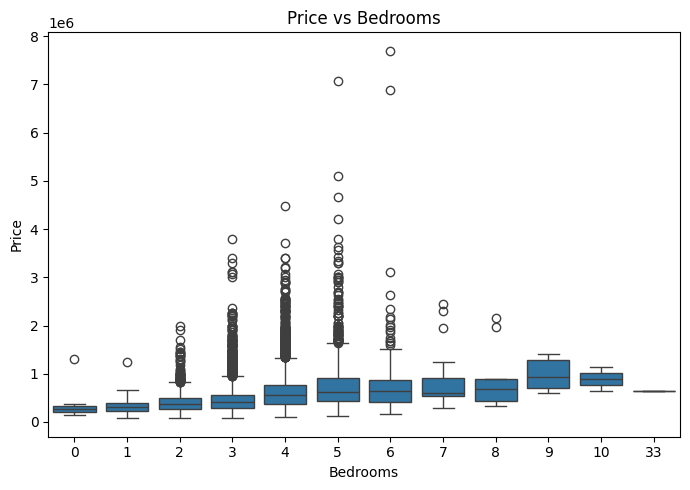

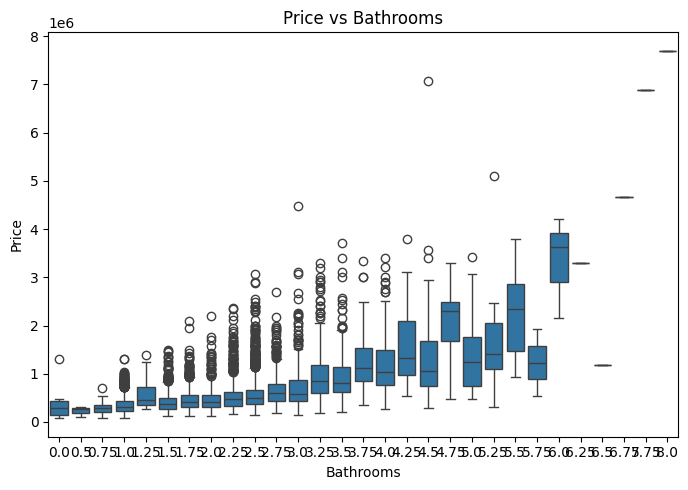

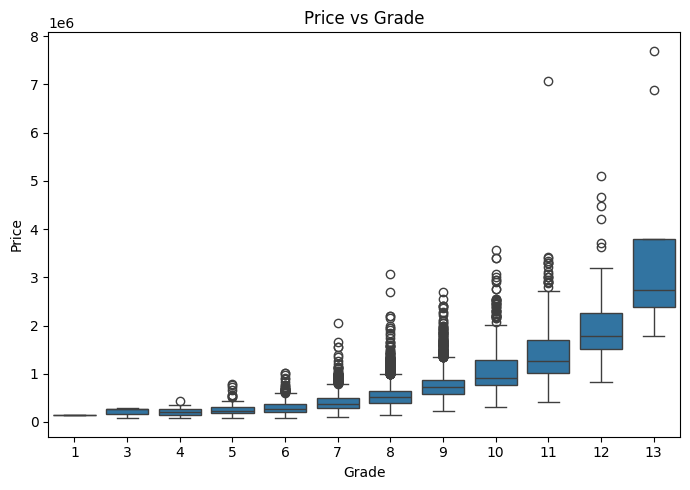

In [ ]:
plt.figure(figsize=(7, 5))
sns.scatterplot(data=df, x="sqft_living", y="price", alpha=0.3)
plt.title("Price vs Sqft Living")
plt.xlabel("Sqft Living")
plt.ylabel("Price")
plt.tight_layout()
plt.show()
plt.figure(figsize=(7, 5))
sns.boxplot(data=df, x="bedrooms", y="price")
plt.title("Price vs Bedrooms")
plt.xlabel("Bedrooms")
plt.ylabel("Price")
plt.tight_layout()
plt.show()
plt.figure(figsize=(7, 5))
sns.boxplot(data=df, x="bathrooms", y="price")
plt.title("Price vs Bathrooms")
plt.xlabel("Bathrooms")
plt.ylabel("Price")
plt.tight_layout()
plt.show()
plt.figure(figsize=(7, 5))
sns.boxplot(data=df, x="grade", y="price")
plt.title("Price vs Grade")
plt.xlabel("Grade")
plt.ylabel("Price")
plt.tight_layout()
plt.show()


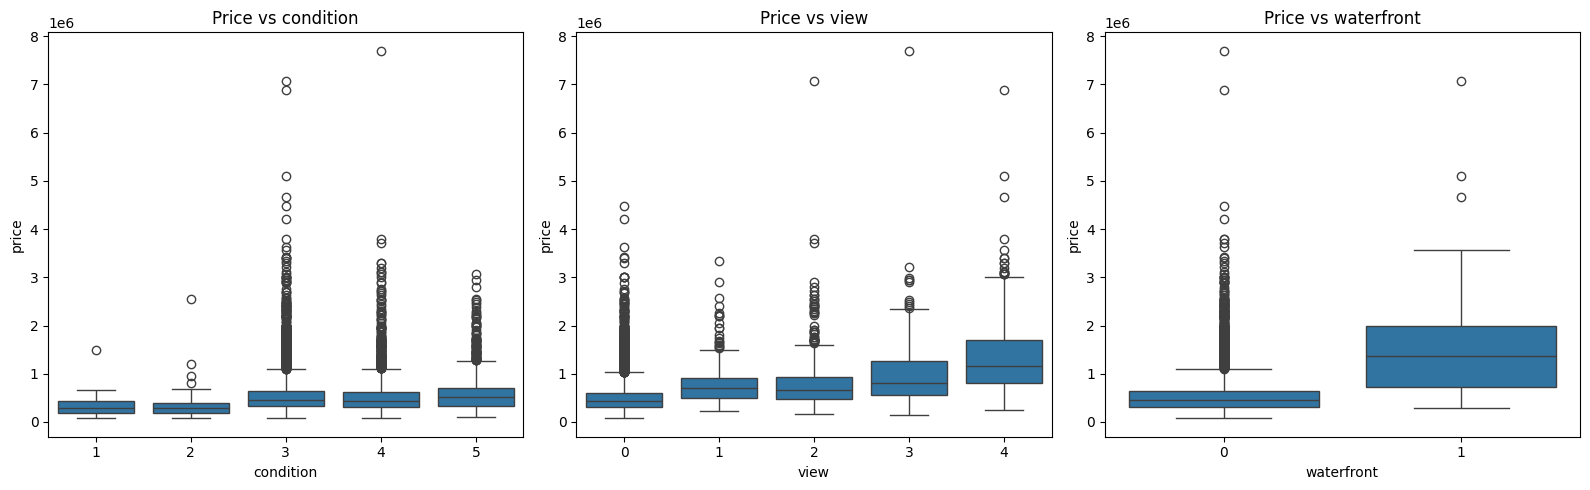

In [ ]:
cat_cols = ["condition", "view", "waterfront"]

fig, axes = plt.subplots(1, 3, figsize=(16,5))
for i, col in enumerate(cat_cols):
    sns.boxplot(ax=axes[i], data=df, x=col, y="price")
    axes[i].set_title(f"Price vs {col}")
plt.tight_layout()
plt.show()

### Correlation Analysis

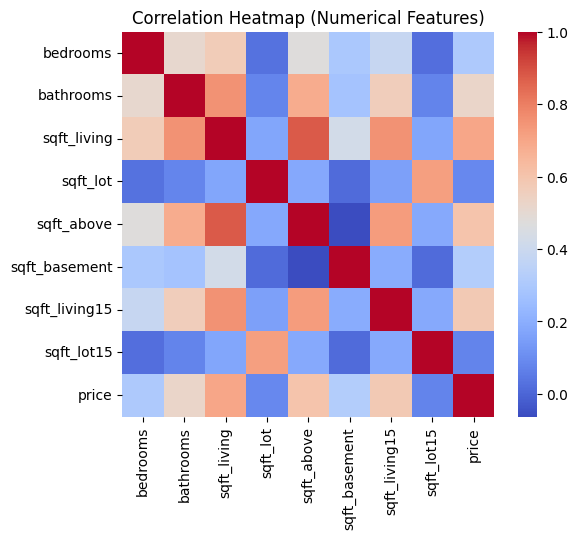

In [ ]:
num_cols = [
    "bedrooms", "bathrooms", "sqft_living", "sqft_lot",
    "sqft_above", "sqft_basement",
    "sqft_living15", "sqft_lot15"
]
plt.figure(figsize=(6,5))
corr = df[num_cols + ["price"]].corr()
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()

### Geospatial EDA

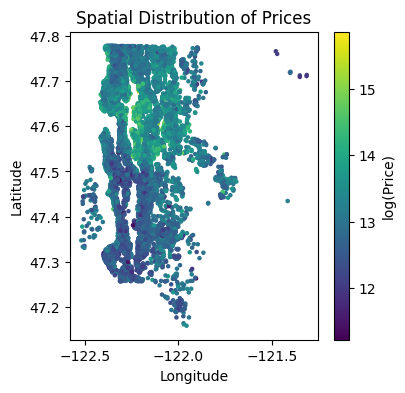

In [ ]:
geometry = [Point(xy) for xy in zip(df["long"], df["lat"])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

plt.figure(figsize=(4,4))
plt.scatter(
    gdf["long"],
    gdf["lat"],
    c=np.log1p(gdf["price"]),
    cmap="viridis",
    s=5
)
plt.colorbar(label="log(Price)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial Distribution of Prices")
plt.show()

### Waterfront vs Non-Waterfront

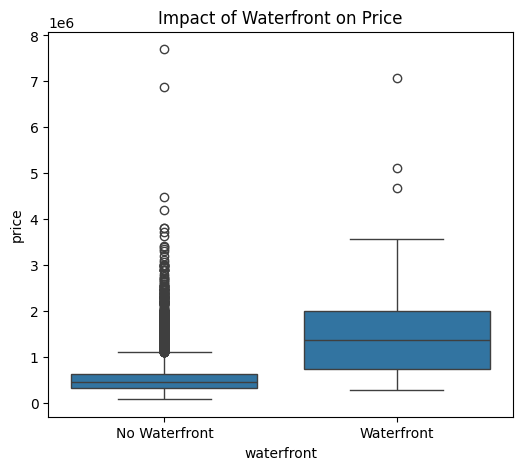

In [ ]:
plt.figure(figsize=(6,5))
sns.boxplot(data=df, x="waterfront", y="price")
plt.xticks([0,1], ["No Waterfront", "Waterfront"])
plt.title("Impact of Waterfront on Price")
plt.show()

### LOAD & VISUALIZE SATELLITE IMAGES

AttributeError: module 'matplotlib.pyplot' has no attribute 'tight_lay'

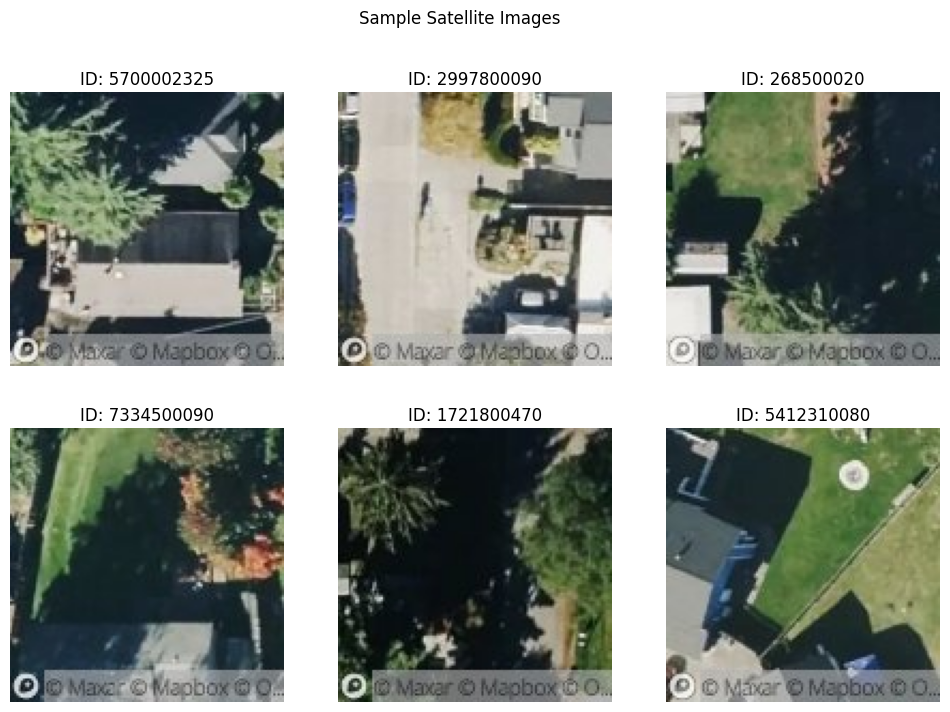

In [ ]:
IMAGE_DIR = "/content/drive/MyDrive/Satellite Imagery Based Property Valuation/images/train"

sample_ids = df["id"].sample(6, random_state=42).values

fig, axes = plt.subplots(2, 3, figsize=(12,8))
for ax, pid in zip(axes.flatten(), sample_ids):
    img_path = os.path.join(IMAGE_DIR, f"{pid}.png")
    if os.path.exists(img_path):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(f"ID: {pid}")
    ax.axis("off")

plt.suptitle("Sample Satellite Images")

In [ ]:
# IMAGE METADATA JOIN CHECK
df["image_path"] = df["id"].apply(
    lambda x: os.path.join(IMAGE_DIR, f"{x}.png")
)

missing_images = df[~df["image_path"].apply(os.path.exists)]
print(f"Missing images: {len(missing_images)}")
missing_images[["id", "lat", "long"]].head()

Missing images: 0


,id,lat,long


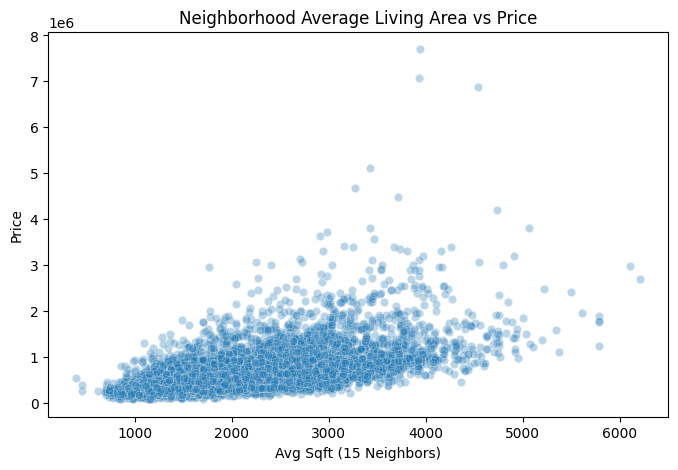

In [ ]:
# NEIGHBORHOOD DENSITY PROXY
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=df,
    x="sqft_living15",
    y="price",
    alpha=0.3
)
plt.title("Neighborhood Average Living Area vs Price")
plt.xlabel("Avg Sqft (15 Neighbors)")
plt.ylabel("Price")
plt.show()

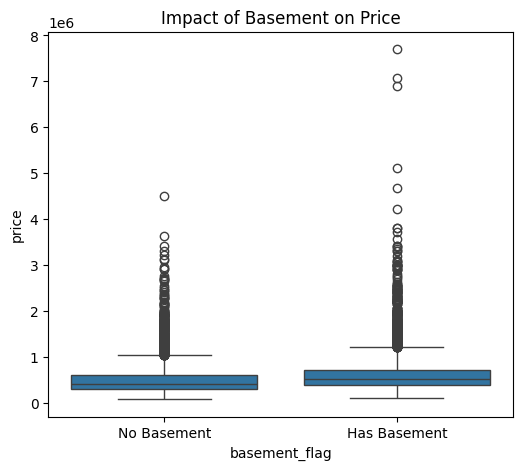

In [ ]:
# BASEMENT & ABOVE-GROUND ANALYSIS
df["basement_flag"] = (df["sqft_basement"] > 0).astype(int)

plt.figure(figsize=(6,5))
sns.boxplot(data=df, x="basement_flag", y="price")
plt.xticks([0,1], ["No Basement", "Has Basement"])
plt.title("Impact of Basement on Price")
plt.show()

### IMAGE PREPROCESSING & CNN FEATURE EXTRACTION


In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print("Using device:", DEVICE)

Using device: cpu


In [ ]:
train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)

print("Train rows:", len(train_df))
print("Test rows :", len(test_df))


Train rows: 16209
Test rows : 5404


In [ ]:
image_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])


In [ ]:
class SatelliteImageDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        pid = self.df.loc[idx, "id"]
        img_path = os.path.join(self.image_dir, f"{pid}.png")

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, pid


In [ ]:
train_dataset = SatelliteImageDataset(
    df=train_df,
    image_dir=TRAIN_IMG_DIR,
    transform=image_transforms
)

test_dataset = SatelliteImageDataset(
    df=test_df,
    image_dir=TEST_IMG_DIR,
    transform=image_transforms
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)


In [ ]:
resnet = models.resnet50(
    weights=models.ResNet50_Weights.IMAGENET1K_V1
)

# Remove classification head
resnet.fc = nn.Identity()

resnet = resnet.to(DEVICE)
resnet.eval()

EMBEDDING_DIM = 2048


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 174MB/s]


In [ ]:
def extract_embeddings(dataloader, model):
    all_embeddings = []
    all_ids = []

    with torch.no_grad():
        for images, pids in tqdm(dataloader):
            images = images.to(DEVICE)

            embeddings = model(images)   # (B, 2048)

            all_embeddings.append(embeddings.cpu().numpy())
            all_ids.extend(pids)

    features = np.vstack(all_embeddings)
    return features, all_ids


In [ ]:
train_features, train_ids = extract_embeddings(train_loader, resnet)

train_img_df = pd.DataFrame(
    train_features,
    columns=[f"img_feat_{i}" for i in range(EMBEDDING_DIM)]
)

train_img_df["id"] = train_ids

print("Train image features shape:", train_img_df.shape)


100%|██████████| 507/507 [1:07:01<00:00,  7.93s/it]


Train image features shape: (16209, 2049)


In [ ]:
test_features, test_ids = extract_embeddings(test_loader, resnet)

test_img_df = pd.DataFrame(
    test_features,
    columns=[f"img_feat_{i}" for i in range(EMBEDDING_DIM)]
)

test_img_df["id"] = test_ids

print("Test image features shape:", test_img_df.shape)


100%|██████████| 169/169 [24:25<00:00,  8.67s/it]


Test image features shape: (5404, 2049)


In [ ]:
train_img_df.to_csv(
    f"{BASE_PATH}/image_embeddings_train.csv",
    index=False
)

test_img_df.to_csv(
    f"{BASE_PATH}/image_embeddings_test.csv",
    index=False
)

print("Image embeddings saved successfully")


Image embeddings saved successfully


### Merge Image Embeddings with Tabular Dat

In [ ]:
BASE_PATH = "/content/drive/MyDrive/Satellite Imagery Based Property Valuation"

# Paths
TRAIN_TABULAR = "/content/drive/MyDrive/Satellite Imagery Based Property Valuation/train(1).csv"
TEST_TABULAR  = "/content/drive/MyDrive/Satellite Imagery Based Property Valuation/test2.csv"
TRAIN_IMG_EMB = f"{BASE_PATH}/image_embeddings_train.csv"
TEST_IMG_EMB  = f"{BASE_PATH}/image_embeddings_test.csv"

# Load with enforced dtype
train_tab = pd.read_csv(TRAIN_TABULAR, dtype={"id": "string"})
test_tab  = pd.read_csv(TEST_TABULAR,  dtype={"id": "string"})

train_img = pd.read_csv(TRAIN_IMG_EMB, dtype={"id": "string"})
test_img  = pd.read_csv(TEST_IMG_EMB,  dtype={"id": "string"})


In [ ]:
def clean_id(series):
    return (
        series.astype(str)
              .str.replace("tensor\\(", "", regex=True)
              .str.replace("\\)", "", regex=True)
              .str.replace(".0", "", regex=False)
              .str.strip()
    )
train_tab["id"] = clean_id(train_tab["id"])
train_img["id"] = clean_id(train_img["id"])

test_tab["id"]  = clean_id(test_tab["id"])
test_img["id"]  = clean_id(test_img["id"])

In [ ]:
print("Common TRAIN IDs:",
      len(set(train_tab["id"]).intersection(set(train_img["id"]))))

print("Common TEST IDs:",
      len(set(test_tab["id"]).intersection(set(test_img["id"]))))

Common TRAIN IDs: 16110
Common TEST IDs: 5396


In [ ]:
train_tab = train_tab.drop_duplicates(subset="id", keep="first")
test_tab  = test_tab.drop_duplicates(subset="id", keep="first")
train_img = train_img.drop_duplicates(subset="id", keep="first")
test_img  = test_img.drop_duplicates(subset="id", keep="first")


In [ ]:
image_feature_cols = [
    c for c in train_img.columns if c != "id"
]

print("Number of image features:", len(image_feature_cols))

Number of image features: 2048


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Scale before PCA (VERY IMPORTANT)
scaler = StandardScaler()

X_train_img = scaler.fit_transform(train_img[image_feature_cols])
X_test_img  = scaler.transform(test_img[image_feature_cols])

# PCA (choose components based on variance or compute)
pca = PCA(n_components=50, random_state=42)  # keeps 95% variance

X_train_pca = pca.fit_transform(X_train_img)
X_test_pca  = pca.transform(X_test_img)

print("PCA components:", X_train_pca.shape[1])


PCA components: 50


In [ ]:
pca_cols = [f"img_pca_{i}" for i in range(X_train_pca.shape[1])]

train_img_pca = pd.DataFrame(
    X_train_pca,
    columns=pca_cols,
    index=train_img.index
)
train_img_pca["id"] = train_img["id"]

test_img_pca = pd.DataFrame(
    X_test_pca,
    columns=pca_cols,
    index=test_img.index
)
test_img_pca["id"] = test_img["id"]


In [ ]:
train_multimodal = train_tab.merge(
    train_img_pca,
    on="id",
    how="inner",
    validate="one_to_one"
)

test_multimodal = test_tab.merge(
    test_img_pca,
    on="id",
    how="left",
    validate="one_to_one"
)


In [ ]:
train_multimodal.to_csv("train_multimodal_pca.csv", index=False)
test_multimodal.to_csv("test_multimodal_pca.csv", index=False)

In [ ]:

os.makedirs(BASE_PATH, exist_ok=True)

train_multimodal.to_csv(
    f"{BASE_PATH}/train_multimodal_pca.csv", index=False
)

test_multimodal.to_csv(
    f"{BASE_PATH}/test_multimodal_pca.csv", index=False
)

In [ ]:
df = pd.read_csv("train_multimodal_pca.csv")
df.head()


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,img_pca_40,img_pca_41,img_pca_42,img_pca_43,img_pca_44,img_pca_45,img_pca_46,img_pca_47,img_pca_48,img_pca_49
0,9117000170,20150505T000000,268643,4,2.25,1810,9240,2.0,0,0,...,1.086034,-1.441703,1.750291,-0.854028,2.182004,-3.441378,-2.008879,-2.337591,1.855482,1.444261
1,6700390210,20140708T000000,245000,3,2.50,1600,2788,2.0,0,0,...,-0.723649,-4.268901,-4.882199,0.612694,-6.312672,1.632437,3.104538,3.789597,2.971212,-4.308125
2,7212660540,20150115T000000,200000,4,2.50,1720,8638,2.0,0,0,...,2.894047,-8.291090,-1.972133,-4.098592,0.057239,-0.944194,-1.911081,5.854003,1.637757,2.702797
3,8562780200,20150427T000000,352499,2,2.25,1240,705,2.0,0,0,...,-3.554165,-0.154154,-0.162911,2.718517,2.625481,0.359115,-2.567920,-0.694147,1.477364,-0.242255
4,7760400350,20141205T000000,232000,3,2.00,1280,13356,1.0,0,0,...,0.211714,-0.875646,2.599976,-3.831130,-0.412094,2.540383,2.491499,-2.714267,2.436773,2.656401


## GradCam Analysis

               id   price
8286    301401410  298000
12277  3629960550  450000
7694   8901500178  700000
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 140MB/s]
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


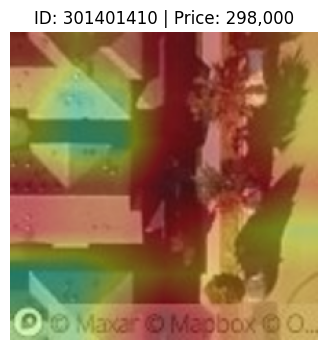

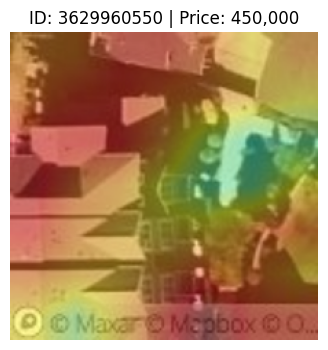

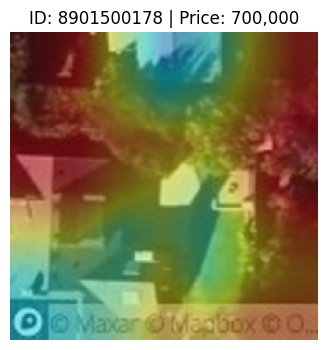

In [2]:
# Grad Cam Analysis

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt


import pandas as pd

# Load training data
df = pd.read_csv(TRAIN_CSV)

# Compute quantiles
low_q  = df["price"].quantile(0.2)
mid_q  = df["price"].quantile(0.5)
high_q = df["price"].quantile(0.8)

# Pick closest samples to each quantile
low_sample  = df.iloc[(df["price"] - low_q).abs().argsort()[:1]]
mid_sample  = df.iloc[(df["price"] - mid_q).abs().argsort()[:1]]
high_sample = df.iloc[(df["price"] - high_q).abs().argsort()[:1]]

selected_df = pd.concat([low_sample, mid_sample, high_sample])

print(selected_df[["id", "price"]])


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

resnet = models.resnet50(
    weights=models.ResNet50_Weights.IMAGENET1K_V1
)
resnet.fc = nn.Identity()
resnet = resnet.to(DEVICE)
resnet.eval()


target_layer = resnet.layer4[-1]


class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self, input_tensor):
        output = self.model(input_tensor)
        score = output.mean()
        self.model.zero_grad()
        score.backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)
        cam = torch.relu(cam)

        cam = cam.squeeze().cpu().detach().numpy()
        cam = cv2.resize(cam, (224, 224))
        cam = (cam - cam.min()) / (cam.max() + 1e-8)

        return cam


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])


import matplotlib.pyplot as plt
import os

IMAGE_DIR = f"{BASE_PATH}/images/train"

gradcam = GradCAM(resnet, target_layer)

for _, row in selected_df.iterrows():
    pid = row["id"]
    price = row["price"]

    img_path = os.path.join(IMAGE_DIR, f"{pid}.png")
    image = Image.open(img_path).convert("RGB")

    input_tensor = transform(image).unsqueeze(0).to(DEVICE)

    cam = gradcam.generate(input_tensor)

    img_np = np.array(image.resize((224,224)))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(4,4))
    plt.imshow(overlay)
    plt.title(f"ID: {pid} | Price: {price:,.0f}")
    plt.axis("off")
    plt.show()